<a id="import-modules"></a>
<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Импорт модулей</h2>

In [4]:
pip install ultralytics

  Using cached ultralytics-8.1.37-py3-none-any.whl (723 kB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id="configuration"></a>
<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Конфигурация</h2>

In [7]:
warnings.filterwarnings("ignore")

np.random.seed(12345)

%matplotlib inline

!wandb disabled

/bin/bash: line 1: wandb: command not found


In [8]:
INPUT_DIR = ''
WORK_DIR = ''

<a id="Data Exploration"></a>
<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Исследование данных</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Создание YAML-файл данных</b></h4>

In [9]:
num_classes = 10
classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

In [10]:
dict_file = {'train': os.path.join(INPUT_DIR, 'train'),
             'val': os.path.join(INPUT_DIR, 'valid'),
             'test': os.path.join(INPUT_DIR, 'test'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join(WORK_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Анализ баланса классов</b></h4>

In [11]:
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join(INPUT_DIR, mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

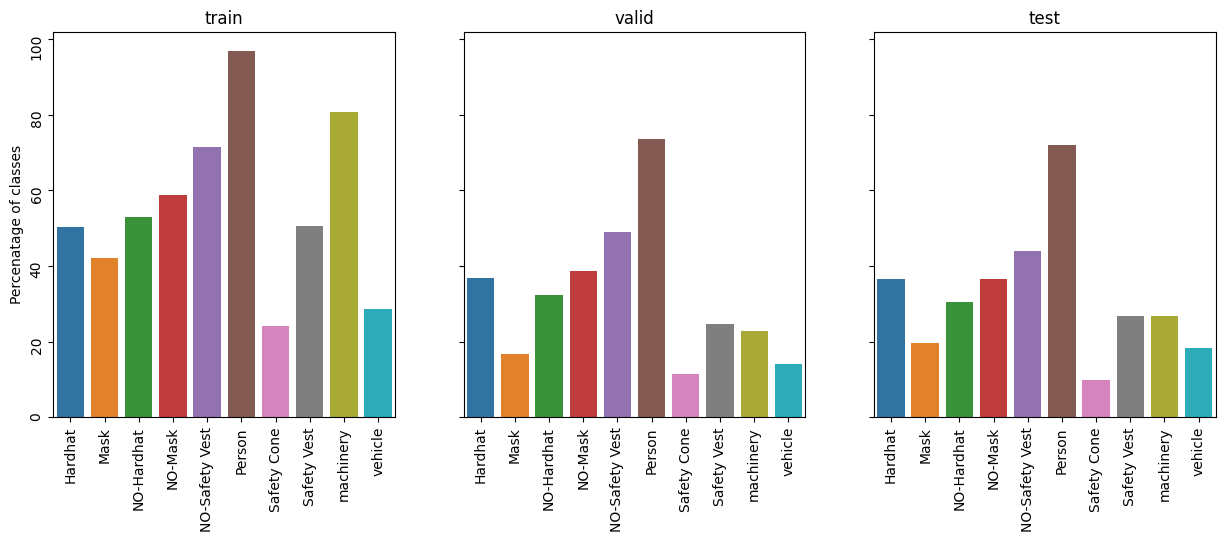

In [12]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(pd.DataFrame({mode:class_stat[mode]}).T/data_len[mode]*100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()

Общее распределение классов между выборками схож, явный дисбаланс классов отсутствует.

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Анализ размеров изображений</b></h4>

In [13]:
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:

	(640, 640)

Image sizes in valid set:

	(640, 640)

Image sizes in test set:

	(640, 640)


Все изображения имеют размер `640x640`.

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Анализ рамеров выборок</b></h4>

In [14]:
for mode in ['train', 'valid', 'test']:

    files =  glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*'))

    print(f'{mode} set size: {len(files)}\n')

train set size: 2605

valid set size: 114

test set size: 82



<a id="train"></a>

<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Обучение</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Загрузка модели<b></h4>

Загрузка `предварительно обученной` модели YOLO Nano/Extra Large

In [36]:
model = YOLO('yolov8n.pt')

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Само обучение</b></h4>

In [37]:
model.train(data=os.path.join(WORK_DIR,'data.yaml'),
            task='detect',
            imgsz=640,
            epochs=30,
            batch=32,
            mode='train',
            name='yolov8n_v1_train')

Ultralytics YOLOv8.1.37 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/GraduateWork/css-data/working/data.yaml, epochs=30, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v1_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop

100%|██████████| 755k/755k [00:00<00:00, 18.5MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/drive/MyDrive/GraduateWork/css-data/train/labels.cache... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/GraduateWork/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/GraduateWork/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/GraduateWork/css-data/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_v1_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_v1_train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.78G      1.388      2.988      1.492        396        640: 100%|██████████| 82/82 [01:26<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]

                   all        114        697       0.47      0.292      0.303      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.31G      1.291      1.861      1.443        251        640: 100%|██████████| 82/82 [01:17<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all        114        697      0.579      0.433      0.472      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       6.4G      1.242      1.647      1.401        293        640: 100%|██████████| 82/82 [01:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

                   all        114        697      0.541      0.453       0.44      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.32G      1.214      1.564      1.379        298        640: 100%|██████████| 82/82 [01:19<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all        114        697      0.512      0.409      0.409      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.94G      1.193      1.497      1.363        237        640: 100%|██████████| 82/82 [01:17<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all        114        697      0.664      0.482      0.516      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.32G      1.172      1.421      1.339        196        640: 100%|██████████| 82/82 [01:19<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all        114        697      0.594      0.511      0.543      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.83G      1.155      1.361      1.321        281        640: 100%|██████████| 82/82 [01:16<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]

                   all        114        697      0.703      0.509       0.56      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.92G      1.128      1.307      1.305        238        640: 100%|██████████| 82/82 [01:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

                   all        114        697      0.656      0.498      0.541      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.63G      1.117      1.269      1.299        254        640: 100%|██████████| 82/82 [01:17<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


                   all        114        697      0.688      0.569      0.606        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.06G      1.108      1.225       1.28        311        640: 100%|██████████| 82/82 [01:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


                   all        114        697        0.7      0.532       0.58      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         6G      1.088        1.2       1.27        168        640: 100%|██████████| 82/82 [01:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        114        697       0.74      0.612      0.652      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.35G      1.074      1.152      1.254        281        640: 100%|██████████| 82/82 [01:17<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all        114        697      0.734      0.597      0.646      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.07G      1.055      1.135      1.251        250        640: 100%|██████████| 82/82 [01:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all        114        697      0.799      0.579      0.663      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.86G      1.049      1.101       1.24        307        640: 100%|██████████| 82/82 [01:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all        114        697      0.761      0.598      0.659      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.53G      1.038      1.085      1.235        199        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all        114        697      0.828      0.605      0.666      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.73G      1.027      1.055      1.223        257        640: 100%|██████████| 82/82 [01:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all        114        697      0.816      0.622      0.692      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.06G       1.01      1.034      1.217        329        640: 100%|██████████| 82/82 [01:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all        114        697      0.782      0.587      0.672      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.89G      1.008       1.01      1.208        311        640: 100%|██████████| 82/82 [01:19<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all        114        697      0.794      0.643      0.702      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.82G      1.001     0.9948      1.206        233        640: 100%|██████████| 82/82 [01:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all        114        697       0.75      0.646      0.694      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.29G     0.9873     0.9743      1.197        251        640: 100%|██████████| 82/82 [01:19<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        114        697      0.794      0.619      0.687      0.379


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.28G      1.016     0.9253      1.214        219        640: 100%|██████████| 82/82 [01:16<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all        114        697       0.84      0.624      0.712       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30       5.2G     0.9959     0.8716      1.199        180        640: 100%|██████████| 82/82 [01:11<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]

                   all        114        697      0.864      0.634      0.724      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.76G     0.9776     0.8491      1.192        179        640: 100%|██████████| 82/82 [01:11<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all        114        697      0.861      0.654      0.731      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.54G     0.9634     0.8257      1.183        139        640: 100%|██████████| 82/82 [01:10<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]

                   all        114        697      0.883      0.641      0.738      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.89G     0.9497     0.8068      1.174        128        640: 100%|██████████| 82/82 [01:12<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all        114        697      0.844      0.664      0.734      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.94G      0.939     0.7942      1.166        141        640: 100%|██████████| 82/82 [01:09<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        697      0.867      0.661      0.736      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.13G     0.9255     0.7753      1.153        226        640: 100%|██████████| 82/82 [01:10<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all        114        697      0.858       0.66      0.743      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.69G     0.9165     0.7571      1.147        176        640: 100%|██████████| 82/82 [01:11<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all        114        697       0.86      0.663      0.745      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.88G     0.8977      0.746      1.141        159        640: 100%|██████████| 82/82 [01:10<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

                   all        114        697      0.831      0.678       0.75      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.41G     0.8929     0.7322       1.13        174        640: 100%|██████████| 82/82 [01:12<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        114        697       0.86      0.681      0.754      0.451



30 epochs completed in 0.678 hours.
Optimizer stripped from runs/detect/yolov8n_v1_train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8n_v1_train/weights/best.pt, 6.3MB

Validating runs/detect/yolov8n_v1_train/weights/best.pt...
Ultralytics YOLOv8.1.37 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


                   all        114        697      0.857      0.683      0.756      0.452
               Hardhat        114         79       0.95      0.734      0.841      0.542
                  Mask        114         21      0.944      0.857      0.916      0.621
            NO-Hardhat        114         69      0.914      0.536      0.625      0.339
               NO-Mask        114         74      0.849      0.486      0.589      0.281
        NO-Safety Vest        114        106      0.842      0.642      0.725      0.411
                Person        114        166      0.859      0.729      0.803      0.492
           Safety Cone        114         44       0.88       0.83      0.857      0.479
           Safety Vest        114         41      0.855      0.732      0.824      0.502
             machinery        114         55      0.836      0.818      0.885      0.555
               vehicle        114         42      0.642      0.469      0.489      0.297
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d179c4a8e50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

**Выбор обученной модели**

In [31]:
path_best_weights="best.pt"
model = YOLO(path_best_weights)

**Prediction**

In [16]:
results = model.predict(source='test/images', save=True)


image 1/82 /content/drive/MyDrive/GraduateWork/css-data/test/images/-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 1 Hardhat, 1 Person, 20.6ms
image 2/82 /content/drive/MyDrive/GraduateWork/css-data/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 2 Hardhats, 2 NO-Masks, 3 Persons, 31.0ms
image 3/82 /content/drive/MyDrive/GraduateWork/css-data/test/images/002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 2 Hardhats, 1 NO-Mask, 2 NO-Safety Vests, 2 Persons, 24.9ms
image 4/82 /content/drive/MyDrive/GraduateWork/css-data/test/images/003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 Hardhat, 2 NO-Masks, 1 NO-Safety Vest, 1 Person, 1 Safety Cone, 15.7ms
image 5/82 /content/drive/MyDrive/GraduateWork/css-data/test/images/004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 5 Hardhats, 4 NO-Safety Vests, 6 Persons, 2 Safety Vests, 19.4ms
image 6/82 /content/drive/MyDrive/GraduateWork/css-data/test/images/004763_jpg.rf.46484